In [59]:
import matplotlib.pyplot as plt
from scipy.special import binom
from functools import partial

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Clifford

from fourier_vqa import *
from tests.test_fourier_vqa import *
from experiments_utils import *

import os
import dill

import networkx as nx
from jax import jit, vmap
import random as rnd
import jax.numpy as jnp

from pandas import DataFrame

# Pointwise convergence

In [126]:
def monomial(x, power):
    return jnp.product(jnp.cos(x) ** (1 - power) * jnp.sin(x) ** power)

@partial(jit, static_argnums=1)
def node_monomial(all_x, node):
    indices, powers = zip(*node.branch_history)
    indices = np.array([indices])
    powers = np.array(powers)
    x = all_x[indices]
    return monomial(x, powers)

def nodes_contribution(all_x, nodes):
    indices_and_powers = [zip(*node.branch_history) for node in nodes]
    x_and_powers = [(jnp.take(all_x, np.array(i)), p) for i, p in indices_and_powers]
    x_and_powers = jnp.array(x_and_powers)
    return vmap(lambda xp: monomial(*xp))(x_and_powers)

def fourier_level_contribution(x, level, fourier_computation):
    nodes_at_level = [node for node in fourier_computation.complete_nodes if node.level==level and node.expectation_value != 0]
    expectation_values = jnp.array([node.expectation_value for node in nodes_at_level])
    if not nodes_at_level:
        return 0
    return (expectation_values*nodes_contribution(x, nodes_at_level)).sum()

In [250]:
num_qubits = 5
num_paulis = 30

fourier_computation = FourierComputation.random(num_qubits, num_paulis, seed=0)
fourier_computation.run()

 90%|██████████████████████████████████████████▎    | 27/30 [00:41<00:04,  1.53s/it, (covered: 100.00%, relative: 100.00%, absolute: 0.031, remaining: 0)]


In [251]:
def plot_contributions_by_level(fourier_computation, num_samples):
    M = fourier_computation.pauli_circuit.num_paulis
    
    stats = []
    for s in range(num_samples):
        x = 2*jnp.pi*random.uniform(random.PRNGKey(s), (M,))
                
        level_contributions = []
        for level in range(M+1):
            level_contribution = fourier_level_contribution(x, level, fourier_computation)
            level_contributions.append(level_contribution)
        
        stats.append(level_contributions)
        
    stats = np.array(stats)
    exact_losses = stats.sum(axis=1, keepdims=True)
    absolute_contributions = np.abs(stats)
    mean_absolute_contributions = np.mean(absolute_contributions, axis=0)
    
    cumulative_contributions = np.array([[sum(contributions[:level]) for level in range(M+1)] for contributions in stats])
    accuracies = np.abs(cumulative_contributions-exact_losses)/np.abs(exact_losses)
    mean_accuracies = np.mean(accuracies, axis=0)
    
    plt.scatter(range(M + 1), mean_absolute_contributions, label='contribs');
    plt.scatter(range(M + 1), mean_accuracies, label='accuracies');
    
    plt.legend()

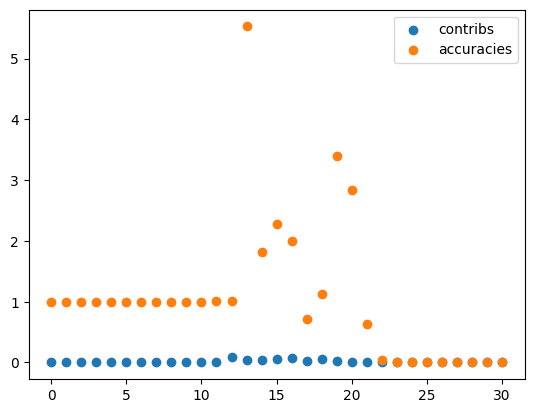

In [254]:
plot_contributions_by_level(fourier_computation, 10);

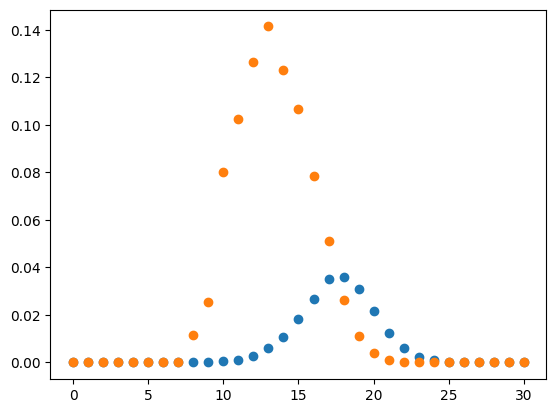

In [255]:
fourier_computation.visualize()

In [263]:
sum(nnorm)

1.0

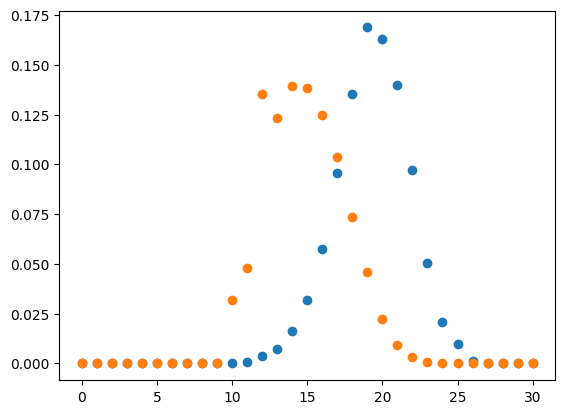

In [264]:
M = fourier_computation.pauli_circuit.num_paulis
nnorm = fourier_computation.norm_stats(only_nonzero=True)
nnorm = np.array(nnorm)/sum(nnorm)
nnode = fourier_computation.node_stats(only_nonzero=True)
nnode = np.array(nnode)/sum(nnode)
plt.scatter(range(M+1), nnode)
plt.scatter(range(M+1), nnorm)

In [261]:



def monomial_array(order, p):
    return vmap(partial(monomial, p))()


def all_monomial_arrays(all_parameters, num_parameters, order):
    parameter_configurations = list(CliffordPhiVQA.parameter_configurations(num_parameters, order))
    parameter_tuples = all_parameters[jnp.array(parameter_configurations)]
    return vmap(partial(monomial_array, order))(parameter_tuples)

In [4]:
num_qubits = 20
degree = 3
level = 3


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(f'num paulis {pauli_circuit.num_paulis}')
fourier_computation = FourierComputation(pauli_circuit, observables[2])
fourier_computation.run()

num paulis 150


 15%|██████▌                                      | 22/150 [16:49<1:37:54, 45.90s/it, (covered: 58.78%, relative: 0.99%, absolute: 0.003, remaining: 0.3)]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_53076/3802340709.py", line 16, in <module>
    fourier_computation.run()
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 424, in run
    self.incomplete_nodes, self.complete_nodes, check_admissible)
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 438, in iteration
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 596, in branch_and_refine
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/fourier_vqa.py", line 523, in remove_commuting_paulis
    num_commuting += 1
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_c

# Random circuits

## Level statistics for fully random circuits

We now collect statistics on the distribution of terms in the dressed Hamiltonian for random circuits.

In [15]:
num_qubits = 30
num_paulis = 25
num_samples = 100

np.random.seed(42)
seeds = np.random.randint(0, 2**32, num_samples)

fourier_stats_samples = []

for seed in tqdm(seeds):
    fourier_computation = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
    # check_admissible=False to get the full expansion of the dressed Hamiltonian
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:40<00:00,  4.00s/it]


And visualize it.

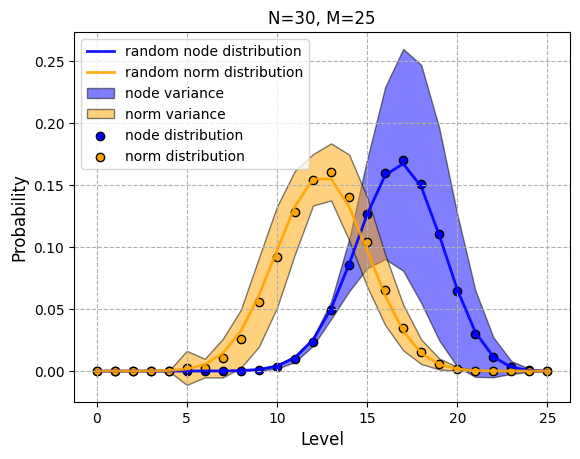

In [16]:
FourierStats.plot_several(fourier_stats_samples)
plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend()
plt.savefig('tex/figures/random.png')

Should be absolete.

## Level statistics for local circuits with random observables

We repeat the computation above, but now only the observale is fully random. Pauli gates are local, bounded by `weight`.

In [17]:
np.random.seed(0)

num_qubits = 30
num_paulis = 25
num_samples = 100

weigth = 2  # Weight of each local pauli gate.

circuit_seeds = np.random.randint(0, 2**32, num_samples)
observable_seeds = np.random.randint(0, 2**32, num_samples)

circuits = [random_local_pauli_circuit(num_qubits, num_paulis, weigth, seed) for seed in circuit_seeds]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]

fourier_stats_samples = []

for seed in tqdm(range(num_samples)):
    seed_circuit, seed_observable = np.random.randint(0, 2**32, 2)
    
    pauli_circuit = random_local_pauli_circuit(num_qubits, num_paulis, weigth, seed_circuit)
    observable = random_pauli(num_qubits, seed_observable)
    
    fourier_computation = FourierExpansionVQA(pauli_circuit, observable)
    # check_admissible=False to get the full expansion of the dressed Hamiltonian
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:36<00:00,  3.97s/it]


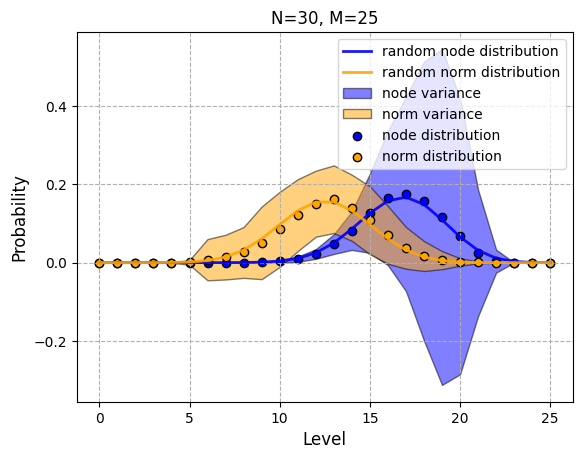

In [18]:
FourierStats.plot_several(fourier_stats_samples)
plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend();

## Estimating complexity of the algorithm

Now let us look at how the complexity of the algorithm scales. For this, we use monte-carlso samplings instead of the full computation and also make prunings of the branches based on the expectation values.

In [84]:
np.random.seed(0)

num_samples_monte_carlo = 10**4
num_sample_circuits = 2

max_num_qubits = 100
step_size = 20
qubits = list(range(5, max_num_qubits+1, step_size))
num_computational_nodes = np.zeros((num_sample_circuits, len(qubits)))

for i, num_qubits in tqdm(list(enumerate(qubits))):
    num_paulis = int(np.ceil(num_qubits/np.log2(3/2)))
    seeds = np.random.randint(0, 2**32, num_sample_circuits)
    for j, seed in enumerate(seeds):
        fourier_expansion = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
        num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
            num_samples=num_samples_monte_carlo, 
            check_admissible=True, 
            verbose=False)
        num_computational_nodes[j, i] = num_nodes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:15<00:00, 39.00s/it]


Now we visualize the data and compare to the theoretical predictions.

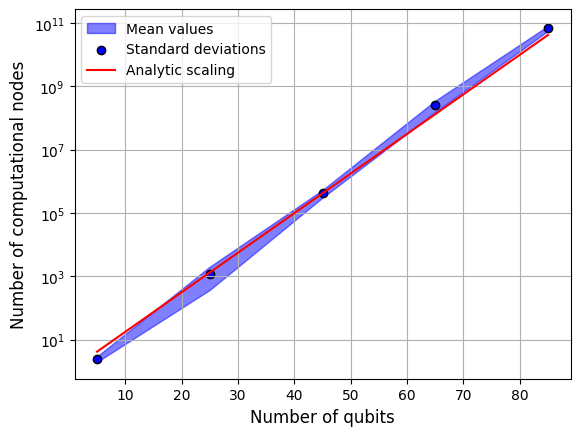

In [109]:
node_means = np.mean(num_computational_nodes, axis=0)
node_variance = np.std(num_computational_nodes, axis=0)

plt.fill_between(qubits, node_means+node_variance, node_means-node_variance, color='blue', alpha=0.5, label='Mean values')
plt.scatter(qubits, node_means, color='blue', edgecolors='black', label='Standard deviations')
plt.plot(qubits, (1.5)**(np.array(qubits)*(1/np.log2(3/2)-1)), color='red', label='Analytic scaling')
plt.xlabel('Number of qubits', fontsize=12)
plt.ylabel('Number of computational nodes', fontsize=12)
plt.grid()
plt.legend()
plt.yscale('log')
plt.savefig('tex/figures/random_mc.png')

# QAOA

## Estimating number of computational nodes.

We will use the bound of the reverse lightcone.

In [26]:
def reverse_light_cone_size(d, p):
    if d<2:
        raise ValueError
    elif d==2:
        return int(2*p+2)
    else:
        return int(2*((d-1)**(p+1)-1)/(d-2))

In [42]:
np.random.seed(0)

num_samples_monte_carlo = 10000
num_sample_circuits = 10

max_level = 3
max_degree = 3

num_computational_nodes = np.zeros((num_sample_circuits, max_degree-1, max_level))

for p in tqdm(range(1, max_level+1)):
    for d in range(2, max_degree+1):
        for s in range(num_sample_circuits):
            num_qubits = reverse_light_cone_size(d, p)
            graph = nx.random_regular_graph(d, num_qubits, seed=int(np.random.randint(0, 2**32)))
            qaoa = QAOA(graph, p)

            observables = qaoa.observables()
            observable = observables[np.random.randint(0, len(observables))]

            fourier_expansion = FourierExpansionVQA(PauliCircuit.from_parameterized_circuit(qaoa.circuit()), observable)
            num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
                num_samples=num_samples_monte_carlo, 
                check_admissible=True, 
                verbose=False)
            num_computational_nodes[s, d-2, p-1] = num_nodes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [21:25<00:00, 428.56s/it]


Means.

In [75]:
num_nodes_means = np.mean(np.log10(num_computational_nodes), axis=0)

idx = index=range(2, max_degree+1)
cols = columns=range(1, max_level+1)
title = 'd \ p'

df_means = DataFrame(num_nodes_means, index=idx, columns=cols)
df_means.style.set_caption('d\p')

,1,2,3
2,0.758792,2.139091,3.933400
3,0.996494,3.699384,8.206022


Deviations.

In [76]:
num_nodes_deviations = np.std(np.log10(num_computational_nodes), axis=0)

df_std = DataFrame(num_nodes_deviations, index=idx, columns=cols)
df_std.style.set_caption('d\p')

,1,2,3
2,0.052244,0.747027,1.055521
3,0.000000,0.025661,0.794275


# Hardware-efficient

In [150]:
def brickwall_circuit(num_qubits, num_blocks):
    
    qc = QuantumCircuit(num_qubits)
    
    parameters = [[Parameter(f'x_{j}{i}') for i in range(4)] for j in range(num_blocks)]
    
    i = 0
    s = 1
    for block_params in parameters:
        if i >= num_qubits-1:
            i = s
            s = (s+1)%2
        
        j = (i+1) % num_qubits
        
        qc.cz(i, j)
        qc.rx(block_params[0], i)
        qc.rx(block_params[1], j)
        qc.rz(block_params[2], i)
        qc.rz(block_params[3], j)
        
        i += 2
    
    return qc

In [163]:
np.random.seed(0)

num_samples_monte_carlo = 10**3
num_sample_circuits = 5

num_qubits = 50
max_M = 600
step_size = 100
M_points = range(4, max_M+1, step_size)

num_computational_nodes = np.zeros((num_sample_circuits, len(M_points)))

for i, M in tqdm(list(enumerate(M_points))):

    seeds = np.random.randint(0, 2**32, num_sample_circuits)
    for j, seed in enumerate(seeds):
        circuit = brickwall_circuit(num_qubits, M//4)
        observable = random_local_pauli(num_qubits, 2, seed) # Weight=2
        fourier_expansion = FourierExpansionVQA(
            PauliCircuit.from_parameterized_circuit(circuit),
            observable)
        num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
            num_samples=num_samples_monte_carlo, 
            check_admissible=True, 
            verbose=False)
        num_computational_nodes[j, i] = num_nodes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:32<00:00, 55.48s/it]


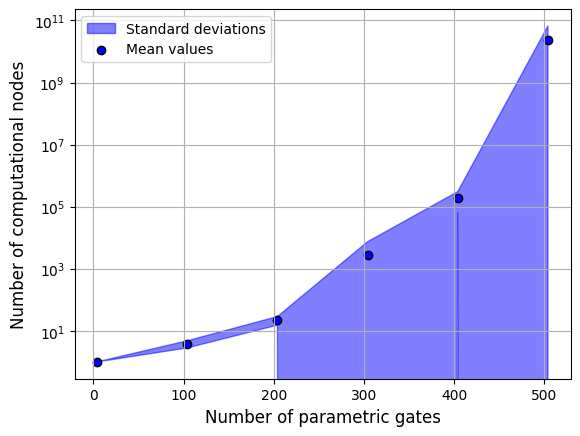

In [164]:
node_means = np.mean(num_computational_nodes, axis=0)
node_variance = np.std(num_computational_nodes, axis=0)

plt.fill_between(M_points, node_means+node_variance, node_means-node_variance, color='blue', alpha=0.5, label='Standard deviations')
plt.scatter(M_points, node_means, color='blue', edgecolors='black', label='Mean values')
plt.xlabel('Number of parametric gates', fontsize=12)
plt.ylabel('Number of computational nodes', fontsize=12)
plt.grid()
plt.legend()
plt.yscale('log')
plt.savefig('tex/figures/hea.png')

In [193]:
np.log2(1.5)

0.5849625007211562